In [1]:
import numpy as np
from scipy.sparse import identity
import numpy as np
from scipy import sparse
from scipy.sparse import lil_matrix
import scipy.sparse.linalg
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
import sys
from qiskit import*
from qiskit import Aer
import qiskit.quantum_info as qi
import numpy as np
import re
from scipy.sparse import identity
import numpy as np
from scipy import sparse
from scipy.sparse import lil_matrix
import scipy.sparse.linalg

In [2]:
Target_state = '0000'
N = len(Target_state)


## The operator U_x.
A = np.ones((2**N, 2**N))
U_x = (2/(2**N))*A - np.identity(2**N, dtype = complex)


## The operator U_0. This is neeed for the sign adjustment of Grover_reconstructed operator.
U_0 = - np.identity(2 ** N, dtype=complex) 
Target_index = int(Target_state, 2)
U_0.itemset((Target_index, Target_index),1)


## G is the Grover operator.
G = np.matrix(np.matmul(U_x, U_0)) # U_w = U_x and U_s = U_0.

In [3]:
def MCX_qiskit(c,t):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.mcx(c,t)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ) 

In [4]:
'''
Qiskit uses little endian notation, where the arrangement of the qubits are reversed.
The Kronecker product for the CNOT gate is modified according to the qiskit notation.
Counting starts from 0 and goes to N-1.

'''
def CNOT(c,t,theta):
    
    '''
    Creating the matrix PI0 (|0><0|) and PI1 (|1><1|).
    
    '''
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    
    '''
    The following function returns the X gate for theta = pi. Any deviation from pi will
    result in a slightly different gate, which is used to model the noisy X gate.
    
    '''
    def Rx(theta):
        return np.around((np.cos(theta/2)*I-1j*X*np.sin(theta/2))*(np.cos(theta/2)*I+1j*I*np.sin(theta/2)),12)
    
    
    Matrices = {'I':I,'PI_0':PI_0,'X':Rx(theta), 'PI_1':PI_1}
    
    
    '''
    
    We will first create two lists p0 and p1 (for PI0 and PI1) with the matrices
    of the Kronecker product of PI0 and PI1.
    
    '''
    p0 = ['I']*N
    p1 = ['I']*N
    
    
    '''
    The string will be modified according to the position of the target and the control qubits.
    
    '''
    
    p0[c] = 'PI_0'
    p1[c] = 'PI_1'
    p1[t] = 'X'

    

    '''  
    Initialize the PI0 and PI1 matrices as the first elemenst of the list p0 and p1,
    then the following loop will perform the Kronecker product.
    
    '''    
    
    
    
    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(Matrices[p0[i]],PI_0_matrix)
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(Matrices[p1[i]],PI_1_matrix)

    return PI_0_matrix+PI_1_matrix

In [5]:
'''

The following function returns the angles theta, phi and lambda; given
the four elements of a 2x2 unitary matrix

                U =  [[A,B]
                      [C,D]].
                      
Input  : Elements A,B,C,D of a matrix M.
Output : Three angles theta, phi and lambda; such that U(theta, phi, lambda) = M.

External link : https://qiskit.org/documentation/stubs/qiskit.circuit.library.U3Gate.html

'''


def InvU(A,B,C,D):
    
    if A == 1:
        
        theta = 0
        if B < 0:
            lamb = (1/1j)*np.log(-B)
        elif B == 0:
            lamb = 0
        else:
            lamb = np.pi+(1/1j)*np.log(B)
    
        if C > 0:
            phi = (1/1j)*np.log(C)
        elif C == 0:
            phi = 0
        else:
            phi = np.pi+(1/1j)*np.log(-C) 
            
            
    else:
        
        theta = 2*np.arccos(A)
        if B < 0:
            lamb = (1/1j)*np.log(-B/np.sqrt(1-A**2))
        else:
            lamb = np.pi+(1/1j)*np.log(B/np.sqrt(1-A**2))
    
        if C > 0:
            phi = (1/1j)*np.log(C/np.sqrt(1-A**2))
        else:
            phi = np.pi+(1/1j)*np.log(-C/np.sqrt(1-A**2))        

    
    return theta.real, phi.real, lamb.real


'''

The following function returns the most general unitary matrix U given the 
parameters theta, phi and lambda.

Input  : theta, phi, lambda.
Output : matrix U.

External link : https://qiskit.org/documentation/stubs/qiskit.circuit.library.U3Gate.html


'''

def U(theta,phi,lamb):
    
    return np.matrix([[np.cos(theta/2), -np.exp(1j*lamb)*np.sin(theta/2)],
                     [np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(phi+lamb))*np.cos(theta/2)]])


'''

The following function returns the square root of a 2x2 matrix of the form

                M =  [[A,B]
                      [C,D]].
                      
Input  : Matrix M
Output : A matrix R such that R^2 = M.

External link : https://en.wikipedia.org/wiki/Square_root_of_a_2_by_2_matrix


'''
def square_root(M):
        
    A = M[0,0]
    B = M[0,1]
    C = M[1,0]
    D = M[1,1]
        
    tau = A+D
    delta = A*D-B*C
    
    if np.imag(delta) == 0:
        if delta>0:
            s = np.sqrt(delta)
        else:
            s = 1j*np.sqrt(-delta)
    else:
        s = np.sqrt(delta)
    
    k = tau+2*s
    if np.imag(k) == 0:  
        if k>0:
            t = np.sqrt(k)
        else:
            t = 1j*np.sqrt(-k)
    else:
        t = np.sqrt(k) 
        
    return (1/t) * (M+s*np.identity(2))

In [6]:
M = np.matrix([[1,2],[3,4]])
M[0,1]

2

## Multcontrolled U gate

In [7]:
'''

The following returns a multicontrolled U gate matrix.

Input  : c (list), t(integer), dagger (True/False).
Output : Matrix of the multicontrolled U gate with control qubits c and target qubit t.

'''
def MCU(c,t,U,dag):
    
    '''
    
    A multicontrolled U gate with controls c (list) and target qubit t is given by 
    
    I x I x ... x I x I - PI1 x PI1 x ... x PI1 x PI1 + PI1 x PI1 x ... x PI1 x U.
    
    
    '''
    
    p0 = ['I']*N
    p1 = ['I']*N
    
    if type(c) == list:
        
        for i in c:
            p0[i] = 'PI_1'
            p1[i] = 'PI_1'
    else:
        p0[c] = 'PI_1'
        p1[c] = 'PI_1'
    p0[t] = 'I'
    p1[t] = 'U'
    
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    
    if dag == False:
        pass
    elif dag == True:
        U = U.getH()
    
    Matrices = {'I':I,'PI_0':PI_0,'U':U, 'PI_1':PI_1}
    

    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(Matrices[p0[i]],PI_0_matrix)
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(Matrices[p1[i]],PI_1_matrix)
        
    return np.identity(2**N)-PI_0_matrix+PI_1_matrix

In [8]:
def MCX(c,t,dag):
    
    '''
    
    A multicontrolled U gate with controls c (list) and target qubit t is given by 
    
    I x I x ... x I x I - PI1 x PI1 x ... x PI1 x PI1 + PI1 x PI1 x ... x PI1 x U.
    
    
    '''
    
    p0 = ['I']*N
    p1 = ['I']*N
    
    if type(c) == list:
        
        for i in c:
            p0[i] = 'PI_1'
            p1[i] = 'PI_1'
    else:
        p0[c] = 'PI_1'
        p1[c] = 'PI_1'
    p0[t] = 'I'
    p1[t] = 'U'
    
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    

        
    if dag == True:
        U = ((1+1j)/2)*(I-1j*X)
    else:
        U = ((1-1j)/2)*(I+1j*X)

    Matrices = {'I':I,'PI_0':PI_0,'U':U, 'PI_1':PI_1}
    

    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(Matrices[p0[i]],PI_0_matrix)
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(Matrices[p1[i]],PI_1_matrix)
        
    return np.identity(2**N)-PI_0_matrix+PI_1_matrix

## Basis gate construction

In [9]:
#N = 3
def Hadamard_gate(): # Hadamad gate acting on one qubit.
    
    return 1/np.sqrt(2)*np.array([[1,1],[1,-1]])

def RY(theta):
    return np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])

def PauliZ():
    return np.array([[1,0],[0,-1]])

# H = RY(pi/2)*Z

def Hadamard(Angle, Qubit): 

    '''

    List below will hold gates acting on one qubit. For example, for L = 3,
    the Hadamard gate acting on the qubit 1 is given by = 1 x H x 1, where 
    x is the Kronecker product. Then, qubits_list = [1,H,1].

    ''' 

    qubits_list = [] 
    
    for i in range(N):
        
        if i == Qubit: # Qubit^th position in the list is H.
            
            qubits_list.append(np.matmul(RY(Angle),PauliZ()))
            
        else: # Other gates are identity operators.
            
            qubits_list.append(np.identity(2))

    '''
    
    The following loop performs the Kronecker product.

    '''        
    
    M = sparse.csr_matrix(qubits_list[0]) # Initializes the final matrix.
    
    for g in range(1,len(qubits_list)):
        
        M = sparse.kron(qubits_list[g],M) # kronecker product.
        
    return M

In [10]:
'''
Qiskit uses little endian notation, where the arrangement of the qubits are reversed.
The Kronecker product for the CNOT gate is modified according to the qiskit notation.
Counting starts from 0 and goes to N-1.

'''
def CNOT(c,t,theta):
    
    '''
    Creating the matrix PI0 (|0><0|) and PI1 (|1><1|).
    
    '''
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    
    '''
    The following function returns the X gate for theta = pi. Any deviation from pi will
    result in a slightly different gate, which is used to model the noisy X gate.
    
    '''
    def Rx(theta):
        return np.around((np.cos(theta/2)*I-1j*X*np.sin(theta/2))*(np.cos(theta/2)*I+1j*I*np.sin(theta/2)),12)
    
    
    Matrices = {'I':I,'PI_0':PI_0,'X':Rx(theta), 'PI_1':PI_1}
    
    
    '''
    
    We will first create two lists p0 and p1 (for PI0 and PI1) with the matrices
    of the Kronecker product of PI0 and PI1.
    
    '''
    p0 = ['I']*N
    p1 = ['I']*N
    
    
    '''
    The string will be modified according to the position of the target and the control qubits.
    
    '''
        
    p0[c] = 'PI_0'
    p1[c] = 'PI_1'
    p1[t] = 'X'

    

    '''  
    Initialize the PI0 and PI1 matrices as the first elemenst of the list p0 and p1,
    then the following loop will perform the Kronecker product.
    
    '''    
    
    
    
    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(Matrices[p0[i]],PI_0_matrix)
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(Matrices[p1[i]],PI_1_matrix)

    return PI_0_matrix+PI_1_matrix

In [11]:
def Rz_matrix(theta):

    return np.matrix([[np.exp(-1j*theta/2),0],[0,np.exp(1j*theta/2)]])

def Rz(Angle, Qubit):
    
    if Qubit > N -1 :
        
        print("Qubit number exceeds N")
        
    else:    
    
        qubits_list = []
    
        for i in range(N):
        
            if i == Qubit:
            
                qubits_list.append(Rz_matrix(Angle))
            
            else:
            
                qubits_list.append(np.matrix(np.identity(2)))
    
        M = sparse.csr_matrix(qubits_list[0])
    
        for g in range(1,len(qubits_list)):
        
            M = sparse.kron(qubits_list[g], M) # kronecker product.
        
        return M

# Custom Grover operator for N = 4

### Multicontrolled NOT gate

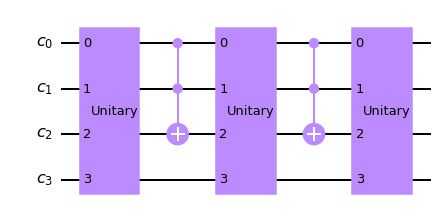

In [12]:
qr = QuantumRegister(N, 'c')
qc = QuantumCircuit(qr)
V0 = MCX(2,3,False)
qc.unitary(V0,[i for i in range(N)])
qc.ccx(qr[0],qr[1],qr[2])
Vdag = MCX(2,3,True)
qc.unitary(Vdag,[i for i in range(N)])
qc.ccx(qr[0],qr[1],qr[2])
V1 = MCX([0,1],3,False)
qc.unitary(V1,[i for i in range(N)])
qc.draw('mpl')

In [13]:
trans_qc = transpile(qc,basis_gates = ['id','rz','h','cx'],optimization_level =2)
len(trans_qc)

1494

### The oracle $U_{0}$

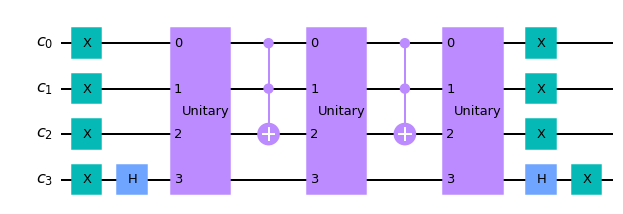

In [14]:
qr = QuantumRegister(4, 'c') # control qubits.
#target_qubit = QuantumRegister(1,'t') # target qubit.
anc = QuantumRegister(1, 'ancilla') # ancilla qubits.
qft = QuantumCircuit(qr)#,anc)

# U_0 gate
qft.x(qr[0])
qft.x(qr[1])
qft.x(qr[2])
qft.x(qr[3])

qft.h(qr[3])
U0 = qft.compose(qc)
U0.h(qr[3])

U0.x(qr[0])
U0.x(qr[1])
U0.x(qr[2])
U0.x(qr[3])

U0.draw('mpl')

In [15]:
trans_U0 = transpile(U0,basis_gates = ['id','rz','h','cx'],optimization_level =2)
len(trans_U0)

1530

In [16]:
f = trans_U0
def List_Gates(Gate_Number):
    
    
    ## The list will hold string along with the angles in case of u3.
    l = []
    
    Name_of_Gate = []
    
    ## The list will hold the qubit in case of u3.
    Qubit = []    
    
    ## The list will hold the numerical value (float) of the angle in case of u3.
    Angle = []

    ## The following two lines will be used to separate the numerical value of the angle from 
    # a mixture of string and digits.
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ )?'
    
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    
    if str(f[Gate_Number][0]).split(',')[0][-3:-1] == 'rz':
        
        Name_of_Gate.append('rz')        
        ## For the gate rz, there is one angle. The following lines puts the string which contain
        # the angle along with other alphabets in a list l.
        l.append(str(list(f)[Gate_Number]).split(',')[3])

        
        ## The following loop extracts the angle from the string of alphabet and digit.
        for i in l:
            
            if rx.findall(i) == []:
                
                ## the angle zero is written as 0.0 .
                Angle.append(0.0)
                
            else:
                
                Angle.append(float(rx.findall(i)[0]))
                
        ## the qubit on which rz acts is listed.        
        Qubit.append(re.sub("\D", "", str(f[Gate_Number][1]).split(',')[2]))  
        
    # For hadamard gates the qubit it is applied to is listed.    
    elif str(f[Gate_Number][0]).split(',')[0][-2:-1] == 'h':
        
        Name_of_Gate.append('h')
        Qubit.append(re.sub("\D", "", str(f[Gate_Number][1]).split(',')[2]))
    
    
        ## if the gate is cx then the Angle list is empty.        
    elif str(f[Gate_Number][0]).split(',')[0][-3:-1] == 'cx':
        
        Name_of_Gate.append('cx')     
        ## the control and the target bit is listed.
        Control_bit = re.sub("\D", '', str(f[Gate_Number][1][0]).split(',')[2])
        
        Target_bit = re.sub("\D", '', str(f[Gate_Number][1][1]).split(',')[2])   
        
        Qubit.append([Control_bit, Target_bit])
    
    
    return Name_of_Gate,Angle, Qubit



# The following list has all the gates in the format [name of the gate, angle, qubit].
l = []
for i in range(len(f)):
    l.append(List_Gates(i))      

## To view the gates, open the following text file.    
file = open('gates_list.txt', 'w')


## The following loop writes the gates into the file.
for i in range(len(l)):
    
    if l[i][0][0] == 'rz':
        
        file.write('rz'+','+str(l[i][1][0])+','+str(l[i][2][0])+','+'\n')

        
    elif l[i][0][0] == 'h':
        
        file.write('h'+','+'0.0'+','+str(l[i][2][0])+','+'\n')
        
        
    elif l[i][0][0] == 'cx':
        
        file.write('cx'+','+l[i][2][0][0]+','+l[i][2][0][1]+','+'\n')
file.close()

In [17]:
l = []

file1 = open('gates_list.txt', 'r')
Lines = file1.readlines()
 

for line in Lines:
    l.append(line.strip())

gates_list = []

for i in range(len(l)):
    
    l_temp = []
    gate_name = l[i].split(',')[0]
    gate_angle = l[i].split(',')[1]
    gate_qubit = l[i].split(',')[2]
    
    l_temp.append(gate_name)
    l_temp.append(gate_angle)
    l_temp.append(gate_qubit)

    gates_list.append(l_temp)

In [18]:
def Oracle_reconstructed():
    

    ## Initializing the oracle U_w as an identity matrix.
    
    Or = identity(2**N) 

    ## In the following loop we multiply all the 1 and 2 qubit gates with (or without) noise.
    
    
    for i in range(len(gates_list)): # l is the list with all the gates.
    
        if gates_list[i][0] == 'rz':
            
            Rz_s = Rz(float(gates_list[i][1]), int(gates_list[i][2]))
            
            Or = Or*Rz_s
            
        
        
        
        elif gates_list[i][0] == 'h':
            
            
            Hs = Hadamard(np.pi/2, int(gates_list[i][2]))
            Or = Or*Hs
            
        
        elif gates_list[i][0] == 'cx':

            Or = Or*CNOT(int(gates_list[i][1]), int(gates_list[i][2]),np.pi)
            
    Or = Or.A   
    return Or

In [19]:
Op = Oracle_reconstructed()

In [20]:
Op = Op/Op[0,0]
Op = np.matmul(U_x,Op)

In [21]:
import numpy
import numpy.linalg

sigma_x=numpy.zeros((2,2),dtype=complex)
sigma_y=numpy.zeros((2,2),dtype=complex)
sigma_z=numpy.zeros((2,2),dtype=complex)
sigma_0=numpy.identity(2,dtype=complex)
sigma_x[0,1]=1.
sigma_x[1,0]=1.
sigma_y[0,1]=-1.j
sigma_y[1,0]=1.j
sigma_z[0,0]=1.
sigma_z[1,1]=-1.
sigma_plus=(sigma_x+1.j*sigma_y)/2.
sigma_minus=(sigma_x-1.j*sigma_y)/2.

def adjoint(psi):
    return psi.conjugate().transpose()

def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())

def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))

def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))

def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns

def comm(a,b):
    return a.dot(b)-b.dot(a)

def anti_comm(a,b):
    return a.dot(b)+b.dot(a)

def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol

def is_unitary(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol

def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)

    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))

    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger

In [22]:
def Phi_F(operator): 
    
    return (1j*np.log(eigu(operator)[0])).real  # eigu(Gr)[0] = exp(-i * phi_F)

In [24]:
Phi_F(Op)

array([ 2.63623214e+00, -5.49560397e-15, -6.18949336e-15, -6.99440506e-15,
       -7.13318293e-15, -7.49400542e-15, -7.99360578e-15, -8.09075029e-15,
       -9.13158438e-15, -1.06303855e-14, -1.06442632e-14, -1.49671942e-14,
       -1.50157664e-14, -1.52308721e-14, -1.81105131e-14, -2.63623214e+00])

# Recursive decomposition

In [50]:
N = 8
Initial_Circ = MCU_Circuit(U,[0,1,2,3,4,5,6],[7])
Initial_Circ[1:][1][1]

matrix([[0, 1],
        [1, 0]])

## Decomposing the circuit.

In [79]:
def Circ_decomp(Circ):
    Q = Circ[1:]
    Qd = []
    for gate in Q:
    
        if len(gate[2]) > 3: # Gates acting on more than 3 qubits needs decomposition.
        
            Qd = Qd[:] + list(MCU_Circuit(gate[1], gate[2], gate[3])[1:])
        
        else: # gates acting on less than or equal to 3 qubits needs no decomposition.
            Qd.append(gate)
    return Qd

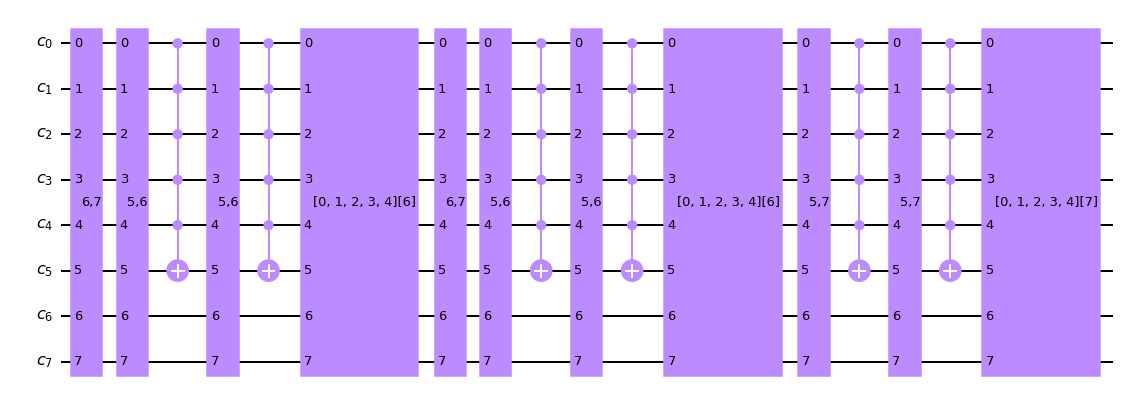

In [82]:
qr = QuantumRegister(N, 'c')
qc = QuantumCircuit(qr)

for i in Circ_decomp(Initial_Circ):
    
    if len(i[2]) == 2: # 2 qubit gate.
        
        Control = i[2][0] # Control qubit.
        Target = i[2][1] # Target qubit.
        V_matrix = i[1] # The matrix V to be applied.
        Gap = 0
        V0 = MCU(Target-Gap-1,Target,V_matrix,False) 
        qc.unitary(V0,[i for i in range(N)],label = str(Control)+','+str(Target))
        
    else: # 3 or more qubit gates.
        
        if i[0] == 'MCX': # MCX gates can be applied directly using qiskit mcx.
            
            qc.mcx(i[2], i[3])
            
        else:
            
            Controls = i[2]
            Target = i[3]
            Gap = Target[0]-Controls[-1]-1
            V_matrix = i[1] # The matrix V to be applied.
            V1 = MCU([i for i in range(Target[0]-Gap-1)],Target[0],V_matrix,False)  
            qc.unitary(V1,[i for i in range(N)],label = str(Controls)+str(Target)) 
qc.draw("mpl")          

In [29]:
'''

The following function returns a circuit decomposition given a multicontrolled 
U gate.

'''
U = np.matrix([[0,1],[1,0]])


N = 8

def MCU_Circuit(Unitary,Controls,Target):    
    qr = QuantumRegister(N, 'c')
    qc = QuantumCircuit(qr)
    
    Gap = Target[0]-Controls[-1]-1
    
    V_matrix = square_root(Unitary)
    X = np.matrix([[0,1],[1,0]])
    
    V0 = MCU(Target[0]-Gap-1,Target[0],V_matrix,False) 
    qc.unitary(V0,[i for i in range(N)],label = 'V')
    
    gate_1 =  ['MCU',V_matrix,[Target[0]-Gap-1,Target[0]]]
    
    
    qc.mcx([qr[i] for i in range(Target[0]-Gap-1)],qr[Target[0]-Gap-1]) 
    
    gate_2 = ['MCX',X,[i for i in range(Target[0]-Gap-1)],[Target[0]-Gap-1]]
    
    
    Vdag = MCU(Target[0]-Gap-1,Target[0],V_matrix.getH(),True)   
    qc.unitary(Vdag,[i for i in range(N)],label = 'V^dag')
    
    gate_3 = ['MCU',V_matrix.getH(),[Target[0]-Gap-1,Target[0]]]
    
    
    qc.mcx([qr[i] for i in range(Target[0]-Gap-1)],qr[Target[0]-Gap-1]) 
    gate_4 = gate_2
    
    
    V1 = MCU([i for i in range(Target[0]-Gap-1)],Target[0],V_matrix,False)  
    qc.unitary(V1,[i for i in range(N)],label = 'V')
    gate_5 = ['MCU',V_matrix,[i for i in range(Target[0]-Gap-1)],[Target[0]]]
    
    return qc,gate_1,gate_2,gate_3,gate_4,gate_5

In [ ]:
N = 6

controls = [0,1,2,3,4]
target = [5]

gap = target[0]-controls[-1]-1
qr = QuantumRegister(N, 'c')
qc = QuantumCircuit(qr)
qc.mcx([i for i in range(target[0]-gap)],target[0])


qc.cx(target[0]-gap-1,target[0])

qc.mcx([i for i in range(target[0]-gap-1)],target[0]-gap-1)

qc.cx(target[0]-gap-1,target[0])
qc.mcx([i for i in range(target[0]-gap-1)],target[0]-gap-1)
qc.mcx([i for i in range(target[0]-gap-1)],target[0])
qc.draw('mpl')